In [1]:
cd ..

D:\Kevin\Machine Learning\Cassava Leaf Disease Classification


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch.optim.optimizer import Optimizer
from adabelief_pytorch import AdaBelief
from ranger_adabelief import RangerAdaBelief
from warmup_scheduler import GradualWarmupScheduler

import timm

from src.dataset import get_loaders
from src.optim import get_optimizer_and_scheduler
from src.engine import get_device, get_net, train_one_epoch, valid_one_epoch
from src import config
from src.utils import *
from src.loss import FocalCosineLoss, SmoothCrossEntropyLoss, bi_tempered_logistic_loss

%matplotlib inline

In [3]:
from IPython.display import FileLinks
FileLinks(config.WEIGHTS_PATH)

./generated/weights\SEResNeXt50_32x4d_BH/
  SEResNeXt50_32x4d_BH_fold_2_11.bin

In [4]:
class GeneralizedCassavaClassifier(nn.Module):
    def __init__(self, model_arch, n_class=5, pretrained=False):
        super().__init__()
        self.name = model_arch
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        model_list = list(self.model.children())
        model_list[-1] = nn.Linear(
            in_features=model_list[-1].in_features,
            out_features=n_class,
            bias=True
        )
        self.model = nn.Sequential(*model_list)

    def forward(self, x):
        x = self.model(x)
        return x
    
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay']
                                     * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class GradualWarmupSchedulerV2(GradualWarmupScheduler):
        def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
            super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
        def get_lr(self):
            if self.last_epoch > self.total_epoch:
                if self.after_scheduler:
                    if not self.finished:
                        self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                        self.finished = True
                    return self.after_scheduler.get_lr()
                return [base_lr * self.multiplier for base_lr in self.base_lrs]
            if self.multiplier == 1.0:
                return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
            else:
                return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]


net = GeneralizedCassavaClassifier(model_arch="resnext50_32x4d")

World Size:                  1
1.4285714285714285e-05
Optimizer:                   RAdam
Scheduler:                   CosineAnnealingWarmRestarts


C:\Users\win10\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
C:\Users\win10\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: htt

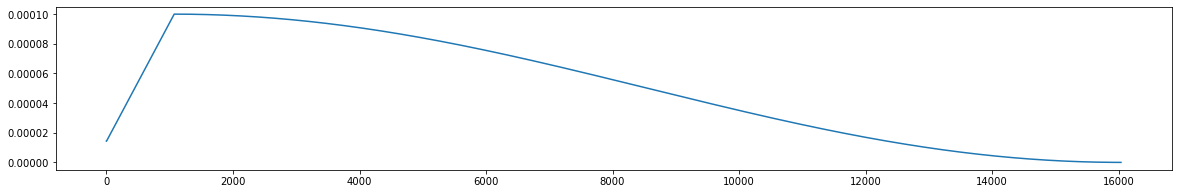

In [7]:
pull = True
fold = 0

if not pull:
    print_fn = print if not config.USE_TPU else xm.master_print
    # m = xm.xrt_world_size() if config.USE_TPU else 1
    m = 1
    print_fn(f"World Size:                  {m}")

    m /= config.WARMUP_FACTOR
    print(config.LEARNING_RATE * m)
    model     = net
    train_loader, valid_loader          = get_loaders(fold)
    optimizer = RAdam(model.parameters(), lr=config.LEARNING_RATE * m)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=5, eta_min=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=14,
                T_mult=1,
                eta_min=0,
                last_epoch=-1)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
    scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=config.WARMUP_FACTOR, total_epoch=config.WARMUP_EPOCHS, after_scheduler=scheduler)

if pull:
    train_loader, valid_loader          = get_loaders(fold)
    optimizer, scheduler                = get_optimizer_and_scheduler(net=net, dataloader=train_loader)

lrs = []
for epoch in range(config.MAX_EPOCHS):
    for step in range(len(train_loader)):
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step(epoch + (step / len(train_loader)))
plt.rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [6]:
for lr in lrs:
    print(lr)

1.4285714285714285e-05
1.436589603100361e-05
1.4446077776292929e-05
1.4526259521582253e-05
1.4606441266871574e-05
1.4686623012160898e-05
1.4766804757450221e-05
1.4846986502739542e-05
1.4927168248028866e-05
1.5007349993318187e-05
1.508753173860751e-05
1.5167713483896834e-05
1.5247895229186155e-05
1.532807697447548e-05
1.5408258719764798e-05
1.548844046505412e-05
1.5568622210343447e-05
1.5648803955632766e-05
1.572898570092209e-05
1.580916744621141e-05
1.5889349191500734e-05
1.596953093679006e-05
1.604971268207938e-05
1.61298944273687e-05
1.6210076172658024e-05
1.6290257917947346e-05
1.637043966323667e-05
1.645062140852599e-05
1.6530803153815314e-05
1.6610984899104633e-05
1.669116664439396e-05
1.6771348389683282e-05
1.6851530134972604e-05
1.6931711880261927e-05
1.701189362555125e-05
1.7092075370840572e-05
1.7172257116129895e-05
1.7252438861419214e-05
1.733262060670854e-05
1.7412802351997863e-05
1.7492984097287182e-05
1.7573165842576508e-05
1.765334758786583e-05
1.773352933315515e-05
1.781

9.995461058041492e-05
9.995416236107809e-05
9.995371194053903e-05
9.99532593188176e-05
9.995280449593372e-05
9.995234747190747e-05
9.995188824675895e-05
9.995142682050843e-05
9.995096319317621e-05
9.995049736478274e-05
9.995002933534855e-05
9.994955910489425e-05
9.994908667344056e-05
9.99486120410083e-05
9.99481352076184e-05
9.994765617329186e-05
9.994717493804976e-05
9.994669150191337e-05
9.994620586490392e-05
9.994571802704286e-05
9.994522798835167e-05
9.994473574885194e-05
9.994424130856538e-05
9.994374466751373e-05
9.994324582571893e-05
9.994274478320292e-05
9.994224153998781e-05
9.994173609609575e-05
9.994122845154903e-05
9.994071860637e-05
9.994020656058115e-05
9.993969231420502e-05
9.993917586726428e-05
9.993865721978168e-05
9.99381363717801e-05
9.993761332328245e-05
9.993708807431182e-05
9.993656062489132e-05
9.993603097504421e-05
9.993549912479382e-05
9.993496507416359e-05
9.993442882317706e-05
9.993389037185786e-05
9.99333497202297e-05
9.99328068683164e-05
9.993226181614192e-

9.722010700428051e-05
9.72166550333951e-05
9.721320098193421e-05
9.720974485005002e-05
9.720628663789482e-05
9.720282634562101e-05
9.719936397338105e-05
9.719589952132752e-05
9.719243298961308e-05
9.718896437839048e-05
9.718549368781253e-05
9.718202091803222e-05
9.717854606920253e-05
9.71750691414766e-05
9.717159013500764e-05
9.716810904994894e-05
9.716462588645389e-05
9.7161140644676e-05
9.71576533247688e-05
9.7154163926886e-05
9.715067245118133e-05
9.714717889780866e-05
9.71436832669219e-05
9.714018555867512e-05
9.713668577322243e-05
9.713318391071806e-05
9.712967997131627e-05
9.712617395517151e-05
9.712266586243825e-05
9.711915569327108e-05
9.711564344782465e-05
9.711212912625377e-05
9.710861272871326e-05
9.710509425535808e-05
9.710157370634326e-05
9.709805108182394e-05
9.709452638195535e-05
9.709099960689279e-05
9.708747075679166e-05
9.708393983180749e-05
9.708040683209584e-05
9.707687175781238e-05
9.70733346091129e-05
9.706979538615326e-05
9.706625408908943e-05
9.706271071807743e-

9.071569472036454e-05
9.070960182112675e-05
9.070350712804309e-05
9.069741064138219e-05
9.069131236141263e-05
9.068521228840315e-05
9.067911042262255e-05
9.067300676433969e-05
9.066690131382355e-05
9.066079407134315e-05
9.065468503716759e-05
9.064857421156608e-05
9.064246159480789e-05
9.063634718716234e-05
9.063023098889888e-05
9.062411300028703e-05
9.061799322159638e-05
9.061187165309653e-05
9.060574829505731e-05
9.05996231477485e-05
9.059349621143997e-05
9.058736748640176e-05
9.05812369729039e-05
9.057510467121654e-05
9.056897058160987e-05
9.05628347043542e-05
9.055669703971992e-05
9.055055758797745e-05
9.054441634939735e-05
9.053827332425023e-05
9.053212851280677e-05
9.052598191533773e-05
9.051983353211396e-05
9.051368336340638e-05
9.050753140948602e-05
9.050137767062393e-05
9.049522214709131e-05
9.048906483915934e-05
9.04829057470994e-05
9.047674487118285e-05
9.047058221168118e-05
9.046441776886594e-05
9.045825154300876e-05
9.045208353438136e-05
9.044591374325552e-05
9.043974216990

8.049701964224393e-05
8.048870162906783e-05
8.048038227242413e-05
8.047206157267945e-05
8.04637395302004e-05
8.045541614535372e-05
8.044709141850614e-05
8.043876535002453e-05
8.043043794027573e-05
8.042210918962672e-05
8.041377909844448e-05
8.040544766709607e-05
8.039711489594863e-05
8.03887807853693e-05
8.038044533572535e-05
8.037210854738408e-05
8.036377042071281e-05
8.0355430956079e-05
8.034709015385009e-05
8.033874801439363e-05
8.033040453807722e-05
8.032205972526847e-05
8.031371357633513e-05
8.030536609164498e-05
8.029701727156579e-05
8.028866711646549e-05
8.028031562671202e-05
8.027196280267337e-05
8.026360864471762e-05
8.025525315321287e-05
8.024689632852733e-05
8.023853817102921e-05
8.023017868108681e-05
8.022181785906849e-05
8.02134557053427e-05
8.020509222027785e-05
8.019672740424253e-05
8.018836125760528e-05
8.017999378073479e-05
8.017162497399976e-05
8.016325483776895e-05
8.015488337241118e-05
8.014651057829536e-05
8.013813645579038e-05
8.012976100526529e-05
8.0121384227089

6.871886754849482e-05
6.870913465967922e-05
6.869940094645604e-05
6.86896664092542e-05
6.86799310485027e-05
6.867019486463046e-05
6.866045785806653e-05
6.865072002923997e-05
6.864098137857986e-05
6.863124190651533e-05
6.862150161347555e-05
6.861176049988972e-05
6.860201856618706e-05
6.859227581279687e-05
6.858253224014841e-05
6.85727878486711e-05
6.856304263879426e-05
6.855329661094734e-05
6.854354976555977e-05
6.853380210306107e-05
6.852405362388074e-05
6.851430432844835e-05
6.850455421719348e-05
6.84948032905458e-05
6.848505154893493e-05
6.847529899279062e-05
6.846554562254259e-05
6.845579143862062e-05
6.844603644145454e-05
6.843628063147415e-05
6.842652400910939e-05
6.841676657479014e-05
6.840700832894638e-05
6.83972492720081e-05
6.83874894044053e-05
6.837772872656807e-05
6.83679672389265e-05
6.835820494191073e-05
6.834844183595094e-05
6.833867792147732e-05
6.832891319892012e-05
6.831914766870958e-05
6.830938133127607e-05
6.82996141870499e-05
6.828984623646148e-05
6.82800774799412e-

5.445478564506512e-05
5.44443315220154e-05
5.4433877203128704e-05
5.442342268886569e-05
5.4412967979687027e-05
5.44025130760534e-05
5.4392057978425484e-05
5.4381602687263994e-05
5.4371147203029644e-05
5.436069152618312e-05
5.435023565718518e-05
5.433977959649653e-05
5.432932334457793e-05
5.43188669018901e-05
5.430841026889383e-05
5.429795344604986e-05
5.428749643381899e-05
5.4277039232661975e-05
5.4266581843039615e-05
5.4256124265412715e-05
5.424566650024209e-05
5.423520854798854e-05
5.4224750409112895e-05
5.421429208407598e-05
5.420383357333865e-05
5.419337487736175e-05
5.418291599660611e-05
5.417245693153264e-05
5.4161997682602174e-05
5.4151538250275605e-05
5.4141078635013827e-05
5.413061883727774e-05
5.412015885752825e-05
5.410969869622627e-05
5.4099238353832695e-05
5.4088777830808485e-05
5.407831712761456e-05
5.406785624471188e-05
5.405739518256139e-05
5.404693394162406e-05
5.403647252236081e-05
5.402601092523269e-05
5.4015549150700645e-05
5.400508719922567e-05
5.399462507126877e-0

4.1839477638208916e-05
4.1829122786971544e-05
4.18187682957793e-05
4.1808414165088466e-05
4.179806039535529e-05
4.178770698703598e-05
4.177735394058677e-05
4.176700125646385e-05
4.175664893512346e-05
4.174629697702168e-05
4.173594538261471e-05
4.1725594152358685e-05
4.171524328670975e-05
4.1704892786123966e-05
4.169454265105744e-05
4.168419288196627e-05
4.1673843479306466e-05
4.1663494443534094e-05
4.1653145775105165e-05
4.164279747447575e-05
4.163244954210174e-05
4.162210197843916e-05
4.161175478394398e-05
4.160140795907216e-05
4.1591061504279583e-05
4.158071542002217e-05
4.157036970675583e-05
4.156002436493644e-05
4.154967939501985e-05
4.153933479746189e-05
4.152899057271843e-05
4.151864672124529e-05
4.1508303243498186e-05
4.149796013993297e-05
4.148761741100539e-05
4.147727505717121e-05
4.1466933078886114e-05
4.1456591476605837e-05
4.1446250250786086e-05
4.143590940188253e-05
4.1425568930350826e-05
4.141522883664664e-05
4.140488912122559e-05
4.139454978454331e-05
4.138421082705537e-

2.9888420509470123e-05
2.9878811680575333e-05
2.98692037383095e-05
2.985959668309591e-05
2.9849990515357935e-05
2.984038523551886e-05
2.9830780844001946e-05
2.9821177341230386e-05
2.9811574727627353e-05
2.9801973003615987e-05
2.979237216961941e-05
2.978277222606063e-05
2.9773173173362665e-05
2.9763575011948527e-05
2.975397774224116e-05
2.9744381364663416e-05
2.9734785879638184e-05
2.9725191287588285e-05
2.9715597588936478e-05
2.9706004784105532e-05
2.9696412873518118e-05
2.968682185759694e-05
2.9677231736764585e-05
2.966764251144361e-05
2.9658054182056627e-05
2.964846674902613e-05
2.963888021277454e-05
2.9629294573724304e-05
2.961970983229781e-05
2.9610125988917415e-05
2.9600543044005405e-05
2.9590960997984046e-05
2.958137985127559e-05
2.9571799604302216e-05
2.956222025748604e-05
2.955264181124921e-05
2.9543064266013787e-05
2.9533487622201813e-05
2.952391188023524e-05
2.951433704053604e-05
2.950476310352612e-05
2.9495190069627356e-05
2.9485617939261565e-05
2.9476046712850548e-05
2.9466

1.7490501208945258e-05
1.7482527539630103e-05
1.7474555303179198e-05
1.7466584499943815e-05
1.7458615130275216e-05
1.745064719452451e-05
1.7442680693042825e-05
1.7434715626181228e-05
1.7426751994290672e-05
1.7418789797722053e-05
1.7410829036826257e-05
1.7402869711954032e-05
1.7394911823456143e-05
1.7386955371683226e-05
1.737900035698586e-05
1.7371046779714597e-05
1.736309464021995e-05
1.7355143938852244e-05
1.734719467596188e-05
1.733924685189912e-05
1.7331300467014165e-05
1.7323355521657195e-05
1.7315412016178275e-05
1.7307469950927456e-05
1.729952932625469e-05
1.7291590142509866e-05
1.728365240004282e-05
1.727571609920337e-05
1.726778124034115e-05
1.7259847823805856e-05
1.7251915849947047e-05
1.724398531911426e-05
1.723605623165694e-05
1.7228128587924466e-05
1.722020238826619e-05
1.7212277633031362e-05
1.720435432256918e-05
1.719643245722875e-05
1.7188512037359207e-05
1.7180593063309533e-05
1.7172675535428653e-05
1.716475945406548e-05
1.71568448195688e-05
1.71489316322874e-05
1.71410

8.501746992021924e-06
8.495893206704423e-06
8.490041250242175e-06
8.48419112289303e-06
8.478342824914797e-06
8.472496356565144e-06
8.466651718101736e-06
8.460808909782085e-06
8.454967931863643e-06
8.449128784603815e-06
8.44329146825989e-06
8.43745598308908e-06
8.431622329348513e-06
8.425790507295277e-06
8.419960517186325e-06
8.41413235927853e-06
8.408306033828765e-06
8.402481541093724e-06
8.396658881330059e-06
8.390838054794368e-06
8.385019061743109e-06
8.379201902432736e-06
8.373386577119522e-06
8.367573086059754e-06
8.3617614295096e-06
8.355951607725142e-06
8.350143620962385e-06
8.34433746947724e-06
8.338533153525584e-06
8.332730673363159e-06
8.326930029245637e-06
8.321131221428652e-06
8.315334250167694e-06
8.309539115718245e-06
8.303745818335611e-06
8.297954358275082e-06
8.292164735791895e-06
8.286376951141144e-06
8.280591004577858e-06
8.27480689635699e-06
8.269024626733422e-06
8.26324419596195e-06
8.257465604297265e-06
8.25168885199402e-06
8.245913939306759e-06
8.240140866489936e-0

2.905473618044646e-06
2.90194891817605e-06
2.898426293656736e-06
2.894905744641912e-06
2.8913872712867436e-06
2.887870873746223e-06
2.8843565521753377e-06
2.8808443067289134e-06
2.877334137561743e-06
2.8738260448284867e-06
2.8703200286837204e-06
2.8668160892819536e-06
2.863314226777569e-06
2.8598144413248646e-06
2.8563167330780847e-06
2.852821102191338e-06
2.8493275488186696e-06
2.8458360731139994e-06
2.8423466752311886e-06
2.838859355324008e-06
2.835374113546096e-06
2.831890950051058e-06
2.828409864992354e-06
2.8249308585233886e-06
2.8214539307974624e-06
2.817979081967775e-06
2.814506312187459e-06
2.811035621609531e-06
2.8075670103869242e-06
2.804100478672472e-06
2.8006360266189354e-06
2.7971736543789926e-06
2.793713362105171e-06
2.7902551499499826e-06
2.7867990180657774e-06
2.783344966604878e-06
2.7798929957194795e-06
2.7764431055616766e-06
2.772995296283498e-06
2.769549568036872e-06
2.7661059209736216e-06
2.762664355245503e-06
2.7592248710041563e-06
2.755787468401144e-06
2.752352147

3.138022025440556e-07
3.1262923900878813e-07
3.114584649197227e-07
3.102898803284459e-07
3.0912348528645547e-07
3.079592798451436e-07
3.0679726405581915e-07
3.056374379696747e-07
3.0447980163781915e-07
3.0332435511127293e-07
3.021710984409398e-07
3.010200316776401e-07
2.9987115487209443e-07
2.9872446807493454e-07
2.975799713366811e-07
2.96437664707766e-07
2.9529754823852115e-07
2.9415962197918976e-07
2.9302388597992053e-07
2.9189034029074577e-07
2.907589849616254e-07
2.896298200424085e-07
2.8850284558284974e-07
2.873780616326038e-07
2.862554682412421e-07
2.851350654582307e-07
2.8401685333293566e-07
2.829008319146342e-07
2.8178700125249254e-07
2.806753613956048e-07
2.7956591239294833e-07
2.784586542934064e-07
2.7735358714577884e-07
2.7625071099875437e-07
2.7515002590093316e-07
2.7405153190080963e-07
2.729552290467951e-07
2.7186111738720097e-07
2.7076919697022746e-07
2.696794678439973e-07
2.6859193005652204e-07
2.675065836557355e-07
2.664234286894551e-07
2.653424652054037e-07
2.642636932

In [7]:
len(train_loader) * 15

16035

In [4]:
df = pd.read_csv(TRAIN_FOLDS)
dataset = CassavaDataset(df=df,
                         data_root=TRAIN_IMAGES_DIR,
                         transforms=get_valid_transforms())
dataloader = DataLoader(dataset,
                        batch_size=3,
                        drop_last=False,
                        num_workers=0,
                        shuffle=False)
device = get_device(n=0)
net = get_net(name=NET, pretrained=False)
net.load_state_dict(torch.load("./generated/weights\SEResNeXt50_32x4d_BH/SEResNeXt50_32x4d_BH_fold_2_11.bin"))
net = net.to(device)

Device:                      GPU


In [6]:
preds = np.empty((0, 5), dtype=np.float64)
for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    predictions = net(images).detach().cpu().numpy()
    preds = np.concatenate([preds, predictions], axis=0)
    
print(preds.shape)

KeyboardInterrupt: 

In [9]:
preds = np.empty((0, 5), dtype=np.float64)